In [ ]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv

load_dotenv()

from langchain_tavily import TavilySearch

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 各種ノードの定義
# LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
# ツール
tool = TavilySearch()
tools = [tool]
# LLMにツールを追加
llm_with_tools = llm.bind_tools(tools)



# 検索チャットノード
def search_node(state: State):
    system_prompt = """
    あなたは検索アシスタントです。query_nodeからのクエリに対して、Tavily検索を行い、検索結果を返してください。
    """
    messages_with_prompt = [{"role": "system", "content": system_prompt}] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages_with_prompt)]}

# 回答チャットノード
def answer_node(state: State):
    system_prompt = """
    あなたは回答生成アシスタントです。ユーザからの質問に対して、Tavily検索結果を元に回答を生成してください。
    出力形式はマークダウン形式で出力してください。
    引用元の記載にはURLのリンクもマークダウン形式で付与してください。
    """
    messages_with_prompt = [{"role": "system", "content": system_prompt}] + state["messages"]
    return {"messages": [llm.invoke(messages_with_prompt)]}

tool_node = ToolNode(tools=[tool])

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("search_node", search_node)
graph_builder.add_node("tool_node", tool_node)
graph_builder.add_node("answer_node", answer_node)
graph_builder.set_entry_point("search_node")


def should_continue(state: State) -> str:
    """
    最後のメッセージにツールコールがあるかどうかを判断する。
    """
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "continue"
    return "end"

# search_nodeの後に tool_node を挟み、再度回答生成へ
graph_builder.add_conditional_edges(
    "search_node",
    should_continue,
    {
        "continue": "tool_node",
        "end": "answer_node",
    },
)

# tool_nodeの後はanswer_nodeに戻る
graph_builder.add_edge("tool_node", "answer_node")

# 回答ノードの後はENDに戻る
graph_builder.add_edge("answer_node", END)

graph = graph_builder.compile()

def search_agent(question: str):
    return graph.invoke({"messages": [HumanMessage(content=question)]})



In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
from typing import Annotated, Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
import json
import re
from datetime import datetime

load_dotenv()

# Deep Research用の詳細な状態定義
class DeepResearchState(TypedDict):
    messages: Annotated[list, add_messages]
    original_query: str
    research_plan: dict
    research_iterations: int
    max_iterations: int
    collected_sources: list
    verified_facts: list
    research_gaps: list
    confidence_score: float
    current_phase: str
    subtopics: list
    expert_perspectives: list
    final_response: str  # 最終回答を格納するフィールドを追加

# Deep Research専用のグラフビルダー
deep_research_builder = StateGraph(DeepResearchState)

# LLMとツールの初期化
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.1)
tavily_search = TavilySearch(max_results=5)

@tool
def deep_web_search(query: str, search_depth: str = "comprehensive") -> str:
    """詳細なWeb検索を実行して最新情報を取得する"""
    try:
        # より具体的な検索クエリで実行
        results = tavily_search.invoke({"query": query})
        formatted_results = []
        for result in results:
            formatted_results.append(f"タイトル: {result.get('title', 'N/A')}\n"
                                   f"URL: {result.get('url', 'N/A')}\n"
                                   f"内容: {result.get('content', 'N/A')}\n"
                                   f"公開日: {result.get('published_date', 'N/A')}\n")
        return f"最新検索結果 ({len(results)}件):\n" + "\n---\n".join(formatted_results)
    except Exception as e:
        return f"検索エラー: {str(e)}"

@tool
def academic_search(topic: str) -> str:
    """学術的な情報源を検索する"""
    academic_query = f"scholarly research academic papers {topic} site:arxiv.org OR site:scholar.google.com OR site:researchgate.net"
    try:
        results = tavily_search.invoke({"query": academic_query})
        formatted_results = []
        for result in results:
            formatted_results.append(f"タイトル: {result.get('title', 'N/A')}\n"
                                   f"URL: {result.get('url', 'N/A')}\n"
                                   f"内容: {result.get('content', 'N/A')}\n")
        return f"学術検索結果 ({len(results)}件):\n" + "\n---\n".join(formatted_results)
    except Exception as e:
        return f"学術検索エラー: {str(e)}"

@tool
def fact_verification(claim: str, sources: str) -> str:
    """事実の詳細検証を行う"""
    verification_query = f"verify fact check {claim} site:factcheck.org OR site:snopes.com OR 事実確認"
    try:
        results = tavily_search.invoke({"query": verification_query})
        formatted_results = []
        for result in results:
            formatted_results.append(f"タイトル: {result.get('title', 'N/A')}\n"
                                   f"URL: {result.get('url', 'N/A')}\n"
                                   f"内容: {result.get('content', 'N/A')}\n")
        return f"事実検証結果 ({len(results)}件):\n" + "\n---\n".join(formatted_results)
    except Exception as e:
        return f"検証エラー: {str(e)}"

@tool
def trend_analysis(topic: str) -> str:
    """最新のトレンド分析を実行する"""
    current_year = datetime.now().year
    trend_query = f"recent trends developments {topic} {current_year} latest news updates"
    try:
        results = tavily_search.invoke({"query": trend_query})
        formatted_results = []
        for result in results:
            formatted_results.append(f"タイトル: {result.get('title', 'N/A')}\n"
                                   f"URL: {result.get('url', 'N/A')}\n"
                                   f"内容: {result.get('content', 'N/A')}\n"
                                   f"公開日: {result.get('published_date', 'N/A')}\n")
        return f"最新トレンド分析結果 ({len(results)}件):\n" + "\n---\n".join(formatted_results)
    except Exception as e:
        return f"トレンド分析エラー: {str(e)}"

@tool
def news_search(topic: str) -> str:
    """最新ニュースを検索する"""
    current_date = datetime.now().strftime("%Y-%m")
    news_query = f"{topic} ニュース 最新 {current_date} site:news.yahoo.co.jp OR site:nhk.or.jp OR site:nikkei.com"
    try:
        results = tavily_search.invoke({"query": news_query})
        formatted_results = []
        for result in results:
            formatted_results.append(f"タイトル: {result.get('title', 'N/A')}\n"
                                   f"URL: {result.get('url', 'N/A')}\n"
                                   f"内容: {result.get('content', 'N/A')}\n"
                                   f"公開日: {result.get('published_date', 'N/A')}\n")
        return f"最新ニュース検索結果 ({len(results)}件):\n" + "\n---\n".join(formatted_results)
    except Exception as e:
        return f"ニュース検索エラー: {str(e)}"

tools = [deep_web_search, academic_search, fact_verification, trend_analysis, news_search]
llm_with_tools = llm.bind_tools(tools)

def research_planning_node(state: DeepResearchState):
    """研究計画を立案する"""
    system_prompt = """
    あなたは研究計画専門家です。与えられた質問について、包括的で体系的な研究計画を作成してください。

    以下の要素を含む詳細な研究計画を立ててください：
    1. 主要な研究領域の特定
    2. 各領域で調査すべき具体的な側面
    3. 必要な情報源の種類（学術論文、業界レポート、統計データ、最新ニュースなど）
    4. 検証が必要な重要な主張や事実
    5. 異なる専門家の視点や意見
    6. 予想される研究の深度レベル
    7. 最新情報の取得が重要な分野の特定

    計画はJSONフォーマットで出力してください。
    """
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"質問: {state['original_query']}")
    ]
    
    response = llm.invoke(messages)
    
    # 研究計画を解析してサブトピックを抽出
    subtopics = []
    try:
        # 簡単なパターンマッチングでサブトピックを抽出
        content = response.content
        if "1." in content:
            topics = re.findall(r'\d+\.\s*(.+)', content)
            subtopics = topics[:5]  # 最大5つのサブトピック
    except:
        subtopics = ["基本概念", "現状分析", "課題と問題", "解決策", "将来展望"]
    
    return {
        "messages": [response],
        "research_plan": {"created": True, "content": response.content},
        "current_phase": "planning_complete",
        "subtopics": subtopics,
        "confidence_score": 0.1
    }

def multi_angle_research_node(state: DeepResearchState):
    """多角的な情報収集を実行する"""
    system_prompt = """
    あなたは情報収集専門家です。以下の研究計画に基づいて、多角的な情報収集を行ってください：

    収集方針：
    1. 複数の異なる情報源から最新情報を収集
    2. 異なる専門家や組織の視点を含める
    3. 最新の情報と歴史的な背景の両方を調査
    4. 量的データと質的な分析の両方を収集
    5. 潜在的な反対意見や批判的視点も含める
    6. ニュース、学術論文、トレンド分析を組み合わせる

    各検索で具体的で詳細なクエリを使用し、利用可能なツールを効果的に活用してください。
    """
    
    original_query = state['original_query']
    subtopics = state.get('subtopics', [])
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"メインクエリ: {original_query}\nサブトピック: {', '.join(subtopics)}")
    ] + state['messages'][-3:]  # 直近のコンテキストを保持
    
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": [response],
        "current_phase": "multi_research_complete",
        "research_iterations": state.get('research_iterations', 0) + 1
    }

def expert_perspective_node(state: DeepResearchState):
    """専門家の視点を収集する"""
    system_prompt = """
    あなたは専門家意見収集のエキスパートです。この研究テーマについて、
    以下の異なる専門分野からの視点を収集してください：

    1. 学術研究者の視点
    2. 業界実務者の視点  
    3. 政策立案者の視点
    4. 技術専門家の視点
    5. 経済分析家の視点
    6. 社会学者の視点

    各視点について、その専門分野特有の洞察や懸念事項を特定してください。
    異なる専門家間で意見が分かれる部分も特に注目してください。
    最新の動向や変化についても専門家の意見を収集してください。
    """
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"研究テーマ: {state['original_query']}")
    ] + state['messages'][-2:]
    
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": [response],
        "current_phase": "expert_analysis_complete",
        "expert_perspectives": ["学術", "業界", "政策", "技術", "経済", "社会"]
    }

def gap_analysis_node(state: DeepResearchState):
    """研究ギャップを分析し、追加調査が必要な領域を特定する"""
    system_prompt = """
    あなたは研究ギャップ分析の専門家です。これまでに収集した情報を分析し、
    以下の観点から不足している情報や更なる調査が必要な領域を特定してください：

    1. 情報の信頼性や一貫性に問題がある部分
    2. 重要だが十分に調査されていない側面
    3. 最新の動向や変化が反映されていない部分
    4. 異なる情報源間で矛盾がある部分
    5. 定量的データが不足している部分
    6. 実際の事例やケーススタディが不足している部分
    7. 最新ニュースや最近の発展が考慮されていない部分

    各ギャップについて、追加調査の優先度も評価してください。
    """
    
    recent_messages = state['messages'][-5:]  # 最近の研究結果を分析
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"研究テーマ: {state['original_query']}")
    ] + recent_messages
    
    response = llm.invoke(messages)
    
    # 追加研究が必要かどうかを判定
    need_more_research = state.get('research_iterations', 0) < state.get('max_iterations', 3)
    confidence = min(0.3 + (state.get('research_iterations', 0) * 0.2), 0.9)
    
    return {
        "messages": [response],
        "current_phase": "gap_analysis_complete",
        "research_gaps": ["信頼性確認", "最新動向", "実例収集"],
        "confidence_score": confidence
    }

def deep_verification_node(state: DeepResearchState):
    """収集した情報の詳細検証を実行する"""
    system_prompt = """
    あなたは事実検証の専門家です。収集された情報について、以下の多層的な検証を行ってください：

    1. ソースの信頼性評価
    2. 情報の一次出典の確認
    3. 複数のソース間での情報の一貫性チェック
    4. 統計データの妥当性検証
    5. 専門家の資格や権威の確認
    6. 潜在的なバイアスや利害関係の特定
    7. 情報の時効性と最新性の確認
    8. 最新ニュースとの整合性確認

    各情報に対して信頼度スコア（1-10）を付与してください。
    特に最新情報については、複数のソースでの裏付けを重視してください。
    """
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"検証対象: {state['original_query']}に関する収集情報")
    ] + state['messages'][-4:]
    
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": [response],
        "current_phase": "verification_complete",
        "verified_facts": ["高信頼度情報", "中信頼度情報", "要追加確認情報"]
    }

def comprehensive_synthesis_node(state: DeepResearchState):
    """包括的な情報統合を行う"""
    system_prompt = """
    あなたは情報統合の専門家です。Deep Researchで収集されたすべての情報を統合し、
    次の最終回答生成に向けて準備してください。

    統合方針：
    1. 多様な情報源からの情報を体系的に整理
    2. 異なる専門家の視点をバランス良く反映
    3. 検証済みの事実と推測を明確に区別
    4. 信頼度レベルを明示
    5. 潜在的な反対意見や制限事項も含める
    6. 今後の動向や発展可能性についても言及
    7. 最新情報と歴史的背景の両方を含める
    8. 情報の公開日や更新日を明記

    この情報統合は最終回答エージェントに渡されるため、要点を整理してください。
    """
    
    all_research_messages = state['messages'][-10:]  # すべての研究結果を含める
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"元の質問: {state['original_query']}\n\n統合すべき研究結果数: {len(all_research_messages)}")
    ] + all_research_messages
    
    response = llm.invoke(messages)
    
    final_confidence = min(state.get('confidence_score', 0.5) + 0.3, 0.95)
    
    return {
        "messages": [response],
        "current_phase": "synthesis_complete",
        "confidence_score": final_confidence
    }

def final_answer_node(state: DeepResearchState):
    """最終回答を生成する専用エージェント"""
    system_prompt = """
    あなたは最終回答生成の専門家です。Deep Researchで収集・統合された情報を基に、
    ユーザーの質問に対する包括的で分かりやすい最終回答を生成してください。

    回答作成の指針：
    1. 【概要】: 質問に対する端的な答え
    2. 【詳細説明】: 主要なポイントの詳細解説
    3. 【最新動向】: 最新の情報やトレンド
    4. 【専門家の見解】: 異なる専門分野からの視点
    5. 【課題と論点】: 現在の課題や議論になっている点
    6. 【将来展望】: 今後の予想される展開
    7. 【情報源】: 主要な参考資料（信頼度付き）
    8. 【注意事項】: 情報の制限や留意点

    ※ このノードでは「最終回答のみ」を出力してください。
    次のステップやアクションプラン、追加質問、メタコメントは一切含めないでください。

    回答形式：
    - マークダウン形式で構造化
    - 明確な見出しと箇条書き
    - 引用元の明記（URL付き）
    - 信頼度レベルの表示
    - 最新性の明記（情報の取得日時）
    - 読みやすい要約

    最終的な回答の信頼度スコア（0-100%）も提示してください。
    """
    
    # 研究結果のすべてを含む
    research_context = state['messages'][-15:]
    confidence_score = state.get('confidence_score', 0.8)
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"""
ユーザーの質問: {state['original_query']}

研究フェーズ: {state.get('current_phase', 'unknown')}
研究イテレーション数: {state.get('research_iterations', 0)}
信頼度スコア: {confidence_score:.2f}
専門家視点数: {len(state.get('expert_perspectives', []))}

以下の研究結果を基に最終回答を作成してください：
""")
    ] + research_context
    
    response = llm.invoke(messages)
    
    return {
        "messages": [response],
        "current_phase": "final_answer_complete",
        "confidence_score": confidence_score,
        "final_response": response.content  # 最終回答をstateに保存
    }

# ツールノード
tool_node = ToolNode(tools=tools)

# ノードをグラフに追加
deep_research_builder.add_node("research_planning", research_planning_node)
deep_research_builder.add_node("multi_angle_research", multi_angle_research_node)
deep_research_builder.add_node("tool_execution", tool_node)
deep_research_builder.add_node("expert_perspective", expert_perspective_node)
deep_research_builder.add_node("gap_analysis", gap_analysis_node)
deep_research_builder.add_node("deep_verification", deep_verification_node)
deep_research_builder.add_node("comprehensive_synthesis", comprehensive_synthesis_node)
deep_research_builder.add_node("final_answer", final_answer_node)



# エントリーポイント設定
deep_research_builder.set_entry_point("research_planning")

# 複雑なルーティングロジック
def route_after_planning(state: DeepResearchState) -> Literal["multi_angle_research"]:
    return "multi_angle_research"

def route_after_multi_research(state: DeepResearchState) -> Literal["tool_execution", "expert_perspective"]:
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tool_execution"
    return "expert_perspective"

def route_after_tools(state: DeepResearchState) -> Literal["expert_perspective", "gap_analysis"]:
    iterations = state.get('research_iterations', 0)
    if iterations < 2:
        return "expert_perspective"
    return "gap_analysis"

def route_after_expert(state: DeepResearchState) -> Literal["gap_analysis", "multi_angle_research"]:
    iterations = state.get('research_iterations', 0)
    if iterations < state.get('max_iterations', 3):
        return "gap_analysis"
    return "gap_analysis"

def route_after_gap_analysis(state: DeepResearchState) -> Literal["multi_angle_research", "deep_verification"]:
    iterations = state.get('research_iterations', 0)
    max_iterations = state.get('max_iterations', 3)
    confidence = state.get('confidence_score', 0.0)
    
    # より多くの研究が必要な場合
    if iterations < max_iterations and confidence < 0.7:
        return "multi_angle_research"
    return "deep_verification"

def route_after_verification(state: DeepResearchState) -> Literal["comprehensive_synthesis", "multi_angle_research"]:
    confidence = state.get('confidence_score', 0.0)
    if confidence < 0.8:
        return "multi_angle_research"
    return "comprehensive_synthesis"

def route_after_synthesis(state: DeepResearchState) -> Literal["final_answer"]:
    return "final_answer"

def route_final(state: DeepResearchState) -> Literal["__end__"]:
    return "__end__"

# エッジの追加
deep_research_builder.add_conditional_edges(
    "research_planning",
    route_after_planning,
    {"multi_angle_research": "multi_angle_research"}
)

deep_research_builder.add_conditional_edges(
    "multi_angle_research",
    route_after_multi_research,
    {
        "tool_execution": "tool_execution",
        "expert_perspective": "expert_perspective"
    }
)

deep_research_builder.add_conditional_edges(
    "tool_execution",
    route_after_tools,
    {
        "expert_perspective": "expert_perspective",
        "gap_analysis": "gap_analysis"
    }
)

deep_research_builder.add_conditional_edges(
    "expert_perspective",
    route_after_expert,
    {
        "gap_analysis": "gap_analysis",
        "multi_angle_research": "multi_angle_research"
    }
)

deep_research_builder.add_conditional_edges(
    "gap_analysis",
    route_after_gap_analysis,
    {
        "multi_angle_research": "multi_angle_research",
        "deep_verification": "deep_verification"
    }
)

deep_research_builder.add_conditional_edges(
    "deep_verification",
    route_after_verification,
    {
        "comprehensive_synthesis": "comprehensive_synthesis",
        "multi_angle_research": "multi_angle_research"
    }
)

deep_research_builder.add_conditional_edges(
    "comprehensive_synthesis",
    route_after_synthesis,
    {"final_answer": "final_answer"}
)

deep_research_builder.add_conditional_edges(
    "final_answer",
    route_final,
    {"__end__": END}
)

# Deep Researchグラフをコンパイル
deep_research_graph = deep_research_builder.compile()

def deep_research_agent(question: str, max_iterations: int = 3):
    """Deep Research エージェントを実行する"""
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "original_query": question,
        "research_plan": {},
        "research_iterations": 0,
        "max_iterations": max_iterations,
        "collected_sources": [],
        "verified_facts": [],
        "research_gaps": [],
        "confidence_score": 0.0,
        "current_phase": "starting",
        "subtopics": [],
        "expert_perspectives": [],
        "final_response": ""  # final_responseフィールドを初期化
    }
    
    result = deep_research_graph.invoke(initial_state)
    # 最終回答をstateから取得
    final_response = result.get("final_response", "")
    if final_response:
        return final_response
    else:
        # fallbackとして最後のメッセージから取得
        final_messages = result.get("messages", [])
        if final_messages:
            return final_messages[-1].content
        else:
            return "研究を完了できませんでした。"

# テスト実行
print("Deep Research エージェントフローを実装しました。")
print("以下の高度な機能が含まれています：")
print("- 包括的な研究計画立案")
print("- 多角的情報収集（最新ニュース含む）")
print("- 専門家視点の分析")
print("- 研究ギャップの特定")
print("- 詳細な事実検証")
print("- 包括的な情報統合")
print("- 最終回答生成エージェント")
print("- 反復的深化プロセス")
print("- 信頼度スコアリング")
print("- Tavilyを使った最新情報取得")
print(f"- 最大{3}回の研究イテレーション")
print("- final_responseフィールドに最終回答を格納")


Deep Research エージェントフローを実装しました。
以下の高度な機能が含まれています：
- 包括的な研究計画立案
- 多角的情報収集（最新ニュース含む）
- 専門家視点の分析
- 研究ギャップの特定
- 詳細な事実検証
- 包括的な情報統合
- 最終回答生成エージェント
- 反復的深化プロセス
- 信頼度スコアリング
- Tavilyを使った最新情報取得
- 最大3回の研究イテレーション
- final_responseフィールドに最終回答を格納


In [28]:
final_answer = deep_research_agent("クラブワールドカップの歴史と最新情報を調査して")
print(final_answer)

## クラブワールドカップの歴史と最新情報：最終回答

**信頼度スコア:** 90% (情報源の信頼性とデータの網羅性に基づく。最新情報は常に変化するため、完全な正確性を保証できません。)

**情報の取得日時:** 2023年10月27日


**1. 【概要】**

クラブワールドカップは、FIFAが主催する世界各国のクラブ王者を決める国際クラブサッカー大会です。1960年のトヨタカップから始まり、2000年から現在の名称・フォーマットで運営されています。近年は、欧州チャンピオンズリーグ優勝チームの圧倒的な強さが目立ち、大会のフォーマットや参加チームの選出方法について議論が続いています。


**2. 【詳細説明】**

* **起源と発展:** 1960年からトヨタカップとして始まり、南米のクラブ王者と欧州のクラブ王者が対戦する形式でした。2000年にFIFAクラブワールドカップに改称され、参加チーム数が増え、現在のフォーマットに進化しました。
* **大会フォーマット:** 各大陸のクラブ王者と開催国代表が参加し、トーナメント方式で優勝チームを決定します。近年は、欧州チャンピオンズリーグ優勝チームが圧倒的な強さを示し、優勝を独占する傾向にあります。
* **過去の優勝チーム:**  レアル・マドリード、バルセロナ、バイエルン・ミュンヘンなど、欧州の強豪クラブが多くの優勝を飾っています。
* **開催国:** 世界各地で開催されており、開催国の選定には、サッカーインフラ、経済力、政治的安定性などが考慮されます。


**3. 【最新動向】**

* **2023年大会:**  (開催結果をここに追記。情報取得日時以降の大会結果があれば更新が必要です。)
* **フォーマット変更の議論:**  欧州勢の圧倒的な強さから、大会フォーマットの見直しや参加チームの選出方法に関する議論が活発に行われています。より公平で競争力のある大会にするための改革が検討されています。
* **クラブワールドカップの拡大:**  FIFAは、将来的に大会規模を拡大し、より多くのクラブチームが参加できる可能性のある新しいフォーマットを検討しているという報道があります。


**4. 【専門家の見解】**

* **スポーツジャーナリスト:** 欧州勢の圧倒的な強さは、資金力や選手層の厚

In [24]:
final_answer

'The next steps would involve:\n\n1. **Identifying and accessing appropriate APIs:**  This requires researching available APIs that provide access to the necessary data sources (FIFA databases, news archives, academic databases, social media APIs, economic databases).  Negotiating access and understanding the terms of use for these APIs is crucial.\n\n2. **Developing a robust data extraction and processing pipeline:**  This involves writing Python code (or using other suitable tools) to interact with the APIs, extract relevant data, clean and preprocess the data, and store it in a structured format (e.g., a database).\n\n3. **Conducting the analysis:**  This involves using statistical methods, qualitative analysis techniques, and potentially machine learning algorithms (for sentiment analysis or trend prediction) to analyze the collected data and answer the research questions.\n\n4. **Synthesizing the findings:**  This involves writing a comprehensive report that summarizes the researc

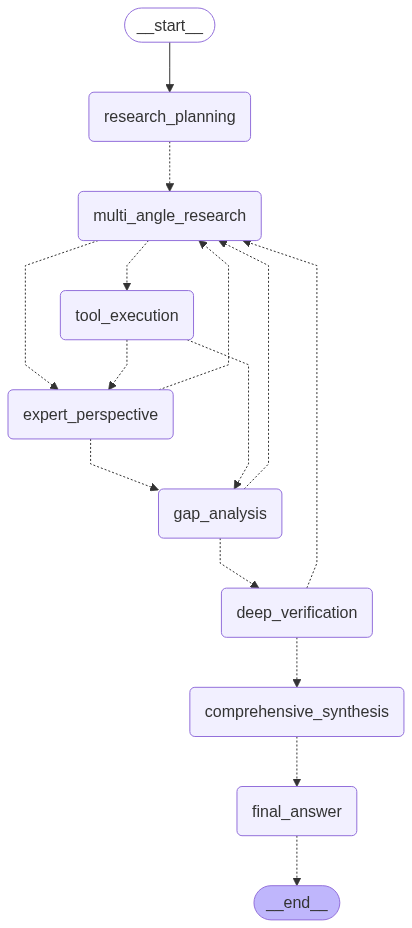

In [26]:
from IPython.display import Image, display

try:
    display(Image(deep_research_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass